

1. PyTorch Basics
    - Toy example with PyTorch
2. Image Classification with PyTorch
    - Implement a simple MLP network for image classification
    - Implement a convolutional network for image classification
    - Experiment with different numbers of layers and optimizers
    - Push the performance of your CNN



In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. pytorch 1.2
2. torchvision
3. numpy
4. matplotlib
```
To install pytorch, please follow the instructions on the [Official website](https://pytorch.org/). In addition, the [official document](https://pytorch.org/docs/stable/) could be very helpful when you want to find certain functionalities. 

You can also consider to use Google Colab, where PyTorch has been installed.

# Section 1. PyTorch Basics

Simply put, PyTorch is a **Tensor** library like Numpy. These two libraries similarly provide useful and efficient APIs for you to deal with your tensor data. What really differentiate PyTorch from Numpy are the following two features:
1. Numerical operations that can **run on GPUs** (more than 10x speedup)
2. Automatic differentiation for building and training neural networks

In this section, we will walk through some simple example, and see how the automatic differentiation functionality can make your life much easier.

### To select GPU in Google Colab:
- go to **Edit -> Notebook settings -> Hardware accelerator -> GPU**

In [ ]:
import torch # import pytorch.
import torch.nn as nn

In [ ]:
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU
#print(torch.cuda.get_device_name(0)) # Check GPU Device name

## 1.1. Automatic Differentiation
Gradient descent is the driving force of the deep learning field. In the lectures and assignment 1, we learned how to derive the gradient for a given function, and implement methods for calculating and performing gradient descents. We also see how we can manually implement the backward and forward functions for the simple NN example. While implementing these functions may not be a big deal for a small network, it may get very nasty when we want to build something with tens of hundreds of layers.

In PyTorch (as well as other major deep learning libraries), we can use autograd ([automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)) to handle the tedious computation of backward passes. When doing forward passes with autograd, we are essentially defining a **computational graph**, while the nodes in the graph are **tensors**, the edges are the functions that produce output tensors (e.g. ReLU, Linear, Convolutional Layer) given the input tensors. To do backpropagation, we can simply backtrack through this graph to compute gradients. 

This may sound a little bit abstract, so let's take a look at the example:

In [ ]:
target = 10.

# create a matrix of size 2x2. Each with value draws from standard normal distribution.
x = torch.randn(2, 2, requires_grad=True) 
y = torch.randn(2, 2, requires_grad=True)

a = x + y
b = a.sum()
loss = b - target

# print out each tensor:
print(x)
print(y)
print(a)
print(b)
print(loss)

print("-----gradient-----")
print(x.grad)
print(y.grad)

tensor([[-0.4944,  1.4592],
        [ 0.4258, -0.0716]], requires_grad=True)
tensor([[-1.2824, -0.2203],
        [-0.4580, -0.4354]], requires_grad=True)
tensor([[-1.7768,  1.2390],
        [-0.0322, -0.5070]], grad_fn=<AddBackward0>)
tensor(-1.0771, grad_fn=<SumBackward0>)
tensor(-11.0771, grad_fn=<SubBackward0>)
-----gradient-----
None
None


In the above example, we have seen a few things:
1. `requires_grad` flag: If false, we can safely exclude this tensor (and its subgraph) from gradient computation and therefore increase efficiency.
2. `grad_fn`: we can see that once an operation is done to a tensor, the output tensor is bound to a backward function associated to the operation. In this case, we have Add, Sum, and Sub.

However, even if we set `requires_grad=True`, we still don't have gradient for `x` and `y`. This is because that we haven't performed the backpropagation yet. So let's do it:

In [ ]:
# perform backpropagation from this "node"
loss.backward()
print('-----gradient-----')
print(x.grad)
print(y.grad)

-----gradient-----
tensor([[1., 1.],
        [1., 1.]])
tensor([[1., 1.],
        [1., 1.]])


Great, seems like we can perform gradient descent without writing backwards function! Now, let's see a simple toy example on how we can fit some weights `w1` and `w2` with random input `x` and target `y`: 

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.  (because we don't need the gradient for the operation 
    # learning_rate * w1.grad)
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

iteration 99: 341.04962158203125
iteration 199: 1.6489198207855225
iteration 299: 0.0150656308978796
iteration 399: 0.00035873911110684276
iteration 499: 5.391986996983178e-05


## 1.2. `nn` Module
Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In PyTorch, the nn package serves this purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

Now, let's see how our simple NN could be implemented using the nn module.

In [ ]:
import torch.nn as nn
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

So far, we have been updating the model parameters manually with `torch.no_grad()`. However, if we want to use optimization algorithms other than SGD, it might get a bit nasty to do it manually. Instead of manually doing this, we can use `optim` pacakge to help optimize our model: 

In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. 
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing nn.Module and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

For example, we can implement our 2-layer simple NN as the following:

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## 1.3. Warm-up: Two-moon datasets 
Now, let's use PyTorch to solve some synthetic datasets. In previous assignment, we have to write some codes to create training batches. Again, this can also be done with PyTorch `DataLoader`. The `DataLoader` utilizes parallel workers to read and prepare batches for you, which can greatly speedup the code when your time bottleneck is on file I/O.

Here, we show a simple example that can create a dataloader from numpy data:

### Setup for Google Colab (Skip for Jupyter Notebook)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Find path to your data folder in drive and enter for "path_to_dataset"
#path_to_dataset = '/content/drive/My Drive/DL_Fall_2020/Assignment_2/data'
path_to_dataset ='C:/Users/sharm/Desktop/Niket_Documents/courses/Deep Learning/Assingments/Assingment 2/HW2/data'
# For Jupyter notebook give path from your local PC

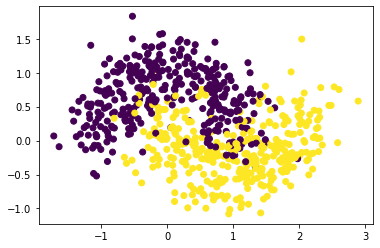

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_train = np.loadtxt(path_to_dataset + '/X1_train.csv', delimiter=',')
X_test = np.loadtxt(path_to_dataset + '/X1_test.csv', delimiter=',')
y_train = np.loadtxt(path_to_dataset + '/y1_train.csv', delimiter=',')
y_test = np.loadtxt(path_to_dataset + '/y1_test.csv', delimiter=',')

# Plot it to see why is it called two-moon dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

Now, let's create a PyTorch `DataLoader`:

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = True # shuffle the dataset

# Convert numpy array import torch tensor
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.reshape(-1, 1))
y_test = torch.LongTensor(y_test.reshape(-1, 1))

# First, create a dataset from torch tensor. A dataset define how to read data
# and process data for creating mini-batches.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          num_workers=num_workers, shuffle=shuffle)

In [ ]:
print(X_train.shape)
print(y_train.shape)

torch.Size([700, 2])
torch.Size([700, 1])


Below, we provide a simple example on how to train your model with this dataloader:

In [ ]:
epoch = 5 # an epoch means looping through all the data in the datasets
lr = 1e-1

# create a simple model that is probably not gonna work well
model = nn.Linear(X_train.size(1), 1)
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
    loss_epoch = 0
    # loop through train loader to get x and y
    for x, y in train_loader:
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = (y_pred - y.float()).abs().mean()
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')

Epcoh 0: 6.804924130439758
Epcoh 1: 4.205340951681137
Epcoh 2: 3.1848054230213165
Epcoh 3: 2.9674482494592667
Epcoh 4: 2.9060702472925186


### 1.3.1 Your Simple NN
Now, it is time for you to implement your own model for this classification task. Your job here is to:
1. Complete the SimpleNN class. It should be a 2- or 3-layer NN with proper non-linearity.
2. Train your model with SGD optimizer.
3. Tune your model a bit so you can achieve at least 80% accuracy on training set.
Hint: you might want to look up `nn.ReLU`, `nn.Sigmoid`, `nn.BCELoss` in the [official document](https://pytorch.org/docs/stable/). You are allowed to freely pick the hyperparameters of your model.
4. **Please note this is a binary classification problem.**

In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self,D_in, H, D_out):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        #D_in = X_train.shape[1]
        #D_out = np.max(y_train) + 1
        #H = 100
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # feed the input to your network, and output the predictions.                  #
        ################################################################################
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
epoch = 10 # an epoch means looping through all the data in the datasets
lr = 1e-1

# create a simple model that is probably not gonna work well

################################################################################
# TODO:                                                                        #
# Initialize your model and SGD optimizer here.  
N, D_in, H, D_out = 64, 700, 100, 2

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = SimpleNN(D_in, H, D_out)

#
################################################################################
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


for e in range(epoch):
    loss_epoch = 0  # record accmulative loss for each epoch
    ################################################################################
    # TODO:                                                                        #
    # Loop through the dataloader and train your model with nn.BCELoss.            #
    ################################################################################
    y_pred = model(x)
    
    loss_epoch = criterion(y_pred, y)
    if e % 10 == 9:
        print(f'iteration {t}: {loss.item()}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()   
    
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

In [ ]:
# helper function for computing accuracy
def get_acc(pred, y):
    pred = pred.float()
    y = y.float()
    return (y==pred).sum().float()/y.size(0)*100.

Evaluate your accuracy:

In [ ]:
y_pred = (model(X_train) > 0.5)
train_acc = get_acc(y_pred, y_train)

y_pred = (model(X_test) > 0.5)
test_acc = get_acc(y_pred, y_test)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

# Section 2. Image Classification with CNN 
Now, we are back to the image classification problem. In this section, our goal is to, again, train models on CIFAR-10 to perform image classification. Your tasks here are to:
1. Build and Train a simple feed-forward Neural Network (consists of only nn.Linear layer with activation function) for the classification task
2. Build and Train a **Convolutional** Neural Network (CNN) for the classification task
3. Try different settings for training your CNN
4. Reproduce

In the following cell, we provide the code for creating a CIFAR10 dataloader. As you can see, PyTorch's `torchvision` package actually has an interface for the CIFAR10 dataset: 

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Preprocessing steps on the training/testing data. You can define your own data augmentation
# here, and PyTorch's API will do the rest for you.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# This will automatically download the dataset for you if it cannot find the data in root
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 2.1 Simple NN
Implement a simple feed-forward neural network, and train it on the CIFAR-10 training set. Here's some specific requirements:
1. The network should only consists of `nn.Linear` layers and the activation functions of your choices (e.g. `nn.Tanh`, `nn.ReLU`, `nn.Sigmoid`, etc). 
2. Train your model with `torch.optim.SGD` with the hyperparameters you like the most. 

Note that the hyperparameters work in previous assignment might not work the same, as the implementations of layers could be different.

### 2.1.1 Design and training 

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [41]:
class SimpleNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        self.fc1 = nn.Linear(32*32*3, 1600) 
        self.fc2 = nn.Linear(1600, 800)
        self.fc3 = nn.Linear(800, 10)
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        # note that: here, the data is of the shape (B, C, H, W)
        # where B is the batch size, C is color channels, and H
        # and W is height and width.
        # To feed it into the linear layer, we need to reshape it
        # with .view() function.
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # reshape the data from (B, C, H, W) to (B, C*H*W)
        ################################################################################
        # TODO:                                                                        #
        # Forward pass, output the prediction score.                                   #
        ################################################################################
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [42]:
epoch = 2
lr = 1e-2
n_input = 3072
n_classes = 10
net = SimpleNN()
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################


In [43]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 12000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.305
[1,  4000] loss: 0.277
[1,  6000] loss: 0.273
[1,  8000] loss: 0.265
[1, 10000] loss: 0.261
[1, 12000] loss: 0.258
[2,  2000] loss: 0.241
[2,  4000] loss: 0.243
[2,  6000] loss: 0.239
[2,  8000] loss: 0.239
[2, 10000] loss: 0.241
[2, 12000] loss: 0.236
Finished Training


In [44]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 53 %


In [45]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 48 %


Now evaluate your model with the helper function:

### 2.1.2 Evaluate NN 
Evaluate your NN. You should get an accuracy around **50%** on training set and **49%** on testing set.

Training - 53%  Testing - 48%

In [ ]:
model = SimpleNN()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

## 2.2 Convolutional Neural Network (CNN)
Convolutional layer has been proven to be extremely useful for vision-based task. As mentioned in the lecture, this speical layer allows the model to learn filters that capture crucial visual features. 



### 2.2.1 Implement and Evaluate CNN 
In this section, you will need to construct a CNN for classifying CIFAR-10 image. Specifically, you need to:
1. build a `CNNClassifier` with `nn.Conv2d`, `nn.Maxpool2d` and activation functions that you think are appropriate. 
2. You would need to flatten the output of your convolutional networks with `view()`, and feed it into a `nn.Linear` layer to predict the class labels of the input. 

Once you are done with your module, train it with `optim.SGD`, and evaluate it. You should get an accuracy around **55%** on training set and **53%** on testing set.



In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [81]:
class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
         # conv2d(no of input channels,number of output channels, kernel size)   the input channel size of CIFAR 10 data is 3
        self.conv_model = nn.Sequential(nn.Conv2d(3,6,5),       # (N,3,32,32) --> (N,6,28,28) in_channels=3,out_channels=6,kernel_size=5
       
                                        nn.ReLU(),                                                 # Relu --> Activation Function

                                        nn.MaxPool2d(2,2),                    # (N,6,28,28) --> (N,6,14,14)               kernel_size=2,stride=2
                                        nn.Conv2d(6,16,5), nn.ReLU(),                             # (N,6,14,14) --> (N,16,10,10)
                                        nn.MaxPool2d(2,2))                                      #(N,16,10,10) --> (N,16,5,5)         kernel_size= 2,stride=2


#Dense Layer
        self.dense_layer = nn.Sequential(nn.Linear(400,10))          #16*5*5 = 400 as input   in_features=400,out_features=120
                                                        #output features = 10


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        y = self.conv_model(x)
        #flatten the result from Conv model
        y = torch.flatten(y,1) # 1 --> dimension (N,16,5,5)
        y = self.dense_layer(y)
        return y
    
net = CNNClassifier()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [82]:
# You can tune these hyperparameters as you like.
num_epochs = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [83]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 12000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [84]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 63 %


In [85]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 60 %


<span style="color:red">**Explain your design and hyperparameter choice in three or four sentences:**</span>

In [ ]:
We get the test accuracy as 60 % and training accuracy as 63 %
Conv, Relu, Pool is considered one set and repeated for the next layer.Filter increase the output channels which are halved by the maxpool.
Conv1 - Relu - Max pool - Conv2 - Relu - Max pool -- Linear Layer (). 
The dimensions of each layer are commented with the two convolution layers consists of 6 size 5 filter in first and 16 filters in the second convolution layer, a lower learning rate 1e-3 gives better accuracy.A lower batch size resuted in faster training at a lower epoch
Repeating this architecture for many CNN layers has been known to give better accuracy.(Source: Pytorch tutorial)

### 2.2.2 STACK MORE LAYERS
Now, **try at least 4 network architectures with different numbers of convolutional layers**. Train these settings with `optim.SGD`, plot the training/testing accuracy as a fuction of convolutional layers and describe what you have observed (running time, performance, etc). **Please make sure your figures are with clear legends and labels**.

In [ ]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################
# Using simular CNN architecture -() CNN- Relu - Maxpool)n - Linear layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Preprocessing steps on the training/testing data. You can define your own data augmentation
# here, and PyTorch's API will do the rest for you.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# This will automatically download the dataset for you if it cannot find the data in root
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [18]:
#1 Conv Layer
class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
         # conv2d(no of input channels,number of output channels, kernel size)   the input channel size of CIFAR 10 data is 3
        self.conv_model = nn.Sequential(nn.Conv2d(3,6,5),       # (N,3,32,32) --> (N,6,28,28) in_channels=3,out_channels=6,kernel_size=5
       
                                        nn.ReLU(),                                                 # Relu --> Activation Function

                                        nn.MaxPool2d(2,2))                    # (N,6,28,28) --> (N,6,14,14)               kernel_size=2,stride=2
                                        


#Dense Layer
        
        self.dense_layer = nn.Sequential(nn.Linear(1176,10))          #6*14*14
                                                  


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        y = self.conv_model(x)
        #flatten the result from Conv model
        y = torch.flatten(y,1) # 1 --> dimension (N,16,5,5)
        y = self.dense_layer(y)
        return y
    
net = CNNClassifier()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [19]:
# You can tune these hyperparameters as you like.
num_epochs = 2
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 12000))
            running_loss = 0.0

print('Finished Training')

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 52 %


In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 47 %


In [23]:
#2 Conv Layer
class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
         # conv2d(no of input channels,number of output channels, kernel size)   the input channel size of CIFAR 10 data is 3
        self.conv_model = nn.Sequential(nn.Conv2d(3,6,5),       # (N,3,32,32) --> (N,6,28,28) in_channels=3,out_channels=6,kernel_size=5
       
                                        nn.ReLU(),                                                 # Relu --> Activation Function

                                        nn.MaxPool2d(2,2),                    # (N,6,28,28) --> (N,6,14,14)               kernel_size=2,stride=2
                                        nn.Conv2d(6,16,5), nn.ReLU(),                             # (N,6,14,14) --> (N,16,10,10)
                                        nn.MaxPool2d(2,2))                                      #(N,16,10,10) --> (N,16,5,5)         kernel_size= 2,stride=2


#Dense Layer
        self.dense_layer = nn.Sequential(nn.Linear(400,10))          #16*5*5 = 400 as input   in_features=400,out_features=120
                                                         #output features = 10


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        y = self.conv_model(x)
        #flatten the result from Conv model
        y = torch.flatten(y,1) # 1 --> dimension (N,16,5,5)
        y = self.dense_layer(y)
        return y
    
net = CNNClassifier()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [24]:
# You can tune these hyperparameters as you like.
num_epochs = 2
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [25]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.893
[1,  4000] loss: 1.626
[1,  6000] loss: 1.531
[1,  8000] loss: 1.491
[1, 10000] loss: 1.444
[1, 12000] loss: 1.415
[2,  2000] loss: 1.361
[2,  4000] loss: 1.330
[2,  6000] loss: 1.347
[2,  8000] loss: 1.358
[2, 10000] loss: 1.344
[2, 12000] loss: 1.341
Finished Training


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 55 %


In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [53]:
#3 Conv layer

class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
         # conv2d(no of input channels,number of output channels, kernel size)   the input channel size of CIFAR 10 data is 3
        self.conv_model = nn.Sequential(nn.Conv2d(3,6,5),       # (N,3,32,32) --> (N,6,28,28) in_channels=3,out_channels=6,kernel_size=5
       
                                        nn.ReLU(),                                                 # Relu --> Activation Function

                                        nn.MaxPool2d(2,2),                    # (N,6,28,28) --> (N,6,14,14)               kernel_size=2,stride=2
                                        nn.Conv2d(6,12,5), nn.ReLU(),                             # (N,6,14,14) --> (N,12,10,10)
                                                                             
                                        nn.Conv2d(12,24,5), nn.ReLU(),         #(N,12,10,10) --> (N,24,6,6)
                                        nn.MaxPool2d(2,2))                     #(N,24,3,3)


#Dense Layer
        self.dense_layer = nn.Sequential(nn.Linear(216,10))          #24*3*3 =  as input   
                                         


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        y = self.conv_model(x)
        #flatten the result from Conv model
        y = torch.flatten(y,1) 
        y = self.dense_layer(y)
        return y
    
net = CNNClassifier()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [65]:
# You can tune these hyperparameters as you like.
num_epochs = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [66]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.876
[1,  4000] loss: 1.638
[1,  6000] loss: 1.522
[1,  8000] loss: 1.472
[1, 10000] loss: 1.472
[1, 12000] loss: 1.448
[2,  2000] loss: 1.389
[2,  4000] loss: 1.369
[2,  6000] loss: 1.349
[2,  8000] loss: 1.373
[2, 10000] loss: 1.367
[2, 12000] loss: 1.337
[3,  2000] loss: 1.284
[3,  4000] loss: 1.298
[3,  6000] loss: 1.307
[3,  8000] loss: 1.313
[3, 10000] loss: 1.313
[3, 12000] loss: 1.289
[4,  2000] loss: 1.267
[4,  4000] loss: 1.241
[4,  6000] loss: 1.261
[4,  8000] loss: 1.291
[4, 10000] loss: 1.274
[4, 12000] loss: 1.263
[5,  2000] loss: 1.234
[5,  4000] loss: 1.245
[5,  6000] loss: 1.271
[5,  8000] loss: 1.273
[5, 10000] loss: 1.256
[5, 12000] loss: 1.256
[6,  2000] loss: 1.213
[6,  4000] loss: 1.220
[6,  6000] loss: 1.226
[6,  8000] loss: 1.274
[6, 10000] loss: 1.245
[6, 12000] loss: 1.243
[7,  2000] loss: 1.201
[7,  4000] loss: 1.244
[7,  6000] loss: 1.239
[7,  8000] loss: 1.245
[7, 10000] loss: 1.220
[7, 12000] loss: 1.238
[8,  2000] loss: 1.218
[8,  4000] 

In [67]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 60 %


In [68]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 56 %


In [74]:
# 4 Conv Layer


class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
         # conv2d(no of input channels,number of output channels, kernel size)   the input channel size of CIFAR 10 data is 3
        self.conv_model = nn.Sequential(nn.Conv2d(3,6,5),       # (N,3,32,32) --> (N,6,28,28) in_channels=3,out_channels=6,kernel_size=5
                                               nn.ReLU(),                                                 # Relu --> Activation Function
                                     
                                        nn.Conv2d(6,12,5), nn.ReLU(),                             # (N,6,28,28) --> (N,12,24,24)
                                        nn.MaxPool2d(2,2),                                         # (N,12,24,24) --> (N,12,12,12)
                                                                             
                                        nn.Conv2d(12,24,5), nn.ReLU(),         #(N,12,12,12) --> (N,24,8,8)
                                        nn.Conv2d(24,48,5), nn.ReLU(),         #  (N,24,8,8)  --> (N,48,4,4) 
                                        nn.MaxPool2d(2,2))                     #(N,48,4,4) --> (N,48,2,2)


#Dense Layer
        self.dense_layer = nn.Sequential(nn.Linear(192,10))          #24*3*3 =  as input   
                                         


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        y = self.conv_model(x)
        #flatten the result from Conv model
        y = torch.flatten(y,1) 
        y = self.dense_layer(y)
        return y
    
net = CNNClassifier()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [75]:
# You can tune these hyperparameters as you like.
num_epochs = 10
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [76]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.062
[1,  4000] loss: 1.766
[1,  6000] loss: 1.664
[1,  8000] loss: 1.565
[1, 10000] loss: 1.517
[1, 12000] loss: 1.470
[2,  2000] loss: 1.395
[2,  4000] loss: 1.357
[2,  6000] loss: 1.346
[2,  8000] loss: 1.326
[2, 10000] loss: 1.307
[2, 12000] loss: 1.302
[3,  2000] loss: 1.203
[3,  4000] loss: 1.238
[3,  6000] loss: 1.250
[3,  8000] loss: 1.200
[3, 10000] loss: 1.218
[3, 12000] loss: 1.208
[4,  2000] loss: 1.152
[4,  4000] loss: 1.129
[4,  6000] loss: 1.156
[4,  8000] loss: 1.167
[4, 10000] loss: 1.161
[4, 12000] loss: 1.147
[5,  2000] loss: 1.075
[5,  4000] loss: 1.111
[5,  6000] loss: 1.129
[5,  8000] loss: 1.123
[5, 10000] loss: 1.134
[5, 12000] loss: 1.115
[6,  2000] loss: 1.043
[6,  4000] loss: 1.086
[6,  6000] loss: 1.094
[6,  8000] loss: 1.069
[6, 10000] loss: 1.102
[6, 12000] loss: 1.093
[7,  2000] loss: 1.024
[7,  4000] loss: 1.047
[7,  6000] loss: 1.055
[7,  8000] loss: 1.066
[7, 10000] loss: 1.088
[7, 12000] loss: 1.072
[8,  2000] loss: 1.008
[8,  4000] 

In [77]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 61 %


In [78]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 56 %


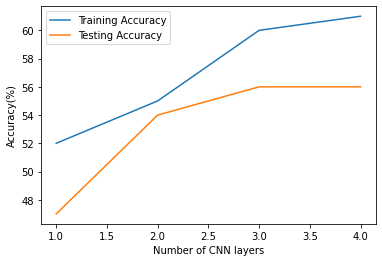

In [80]:
import matplotlib.pyplot as plt 
n_layer = [1, 2, 3, 4]   #Number of CNN layers
acc_trg = [52,55,60,61]

acc_test = [47,54,56,56]

plt.plot(n_layer,acc_trg)
plt.plot(n_layer,acc_test)

plt.xlabel('Number of CNN layers')
plt.ylabel('Accuracy(%)')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')

<span style="color:red">****</span>
Stacking layers after acertain point leads to overfitting without regularization like drop out.The test accuracy increases with each layers but the difference between test and train acccuracy starts increasing with each layer due to overfitting without regularization.Also running time increases with each layer

### 2.2.3 Optimizer? Optimizer! 
So far, we only use SGD as our optimizer. Now, pick two other optimizers, train your favorite CNN models, and compare the performance you get. What did you see?

In [ ]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [69]:
#2 Conv Layer
class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
         # conv2d(no of input channels,number of output channels, kernel size)   the input channel size of CIFAR 10 data is 3
        self.conv_model = nn.Sequential(nn.Conv2d(3,6,5),       # (N,3,32,32) --> (N,6,28,28) in_channels=3,out_channels=6,kernel_size=5
       
                                        nn.ReLU(),                                                 # Relu --> Activation Function

                                        nn.MaxPool2d(2,2),                    # (N,6,28,28) --> (N,6,14,14)               kernel_size=2,stride=2
                                        nn.Conv2d(6,16,5), nn.ReLU(),                             # (N,6,14,14) --> (N,16,10,10)
                                        nn.MaxPool2d(2,2))                                      #(N,16,10,10) --> (N,16,5,5)         kernel_size= 2,stride=2


#Dense Layer
        self.dense_layer = nn.Sequential(nn.Linear(400,10))          #16*5*5 = 400 as input   in_features=400,out_features=120
                                         #nn.ReLU(),
                                         #nn.Linear(120,84),                       #Dense Layer 1: 120 Neurons
                                         #nn.ReLU(),
                                         #nn.Linear(84,10))                   #output features = 10


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        y = self.conv_model(x)
        #flatten the result from Conv model
        y = torch.flatten(y,1) # 1 --> dimension (N,16,5,5)
        y = self.dense_layer(y)
        return y
    
net = CNNClassifier()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [70]:
num_epochs = 20
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################




In [ ]:
#Adam optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)


In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 58 %


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 56 %


In [ ]:
#RMSprop optimizer
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

In [ ]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 65 %


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 60 %


In [ ]:
Test accuracy - Adam = 56, RMS PRop = 60
 

RMSProp optimizer performs better than Adams prop Keeping other hyparameters parameters same like the number of layer learning rate, epoch, batch size etc., although it takes longer tiem to train using Admas prop

### 2.2.4 Improve Your Model 


In [ ]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import torchvision
import torchvision.transforms as transforms

# Preprocessing steps on the training/testing data. You can define your own data augmentation
# here, and PyTorch's API will do the rest for you.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# This will automatically download the dataset for you if it cannot find the data in root
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
         # conv2d(no of input channels,number of output channels, kernel size,padding)   the input channel size of CIFAR 10 data is 3
         #BatchNorm2d(number of channels)
         #Maxpool2D(kernel size, stride)
          #nn.Dropout2d(p)
        self.conv_model = nn.Sequential(
            # Conv Layer block 1
                                        nn.Conv2d(3, 32, kernel_size=3, padding=1),
                                        nn.BatchNorm2d(32),
                                        nn.ReLU(),
                                        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            # Conv Layer block 2
                                        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(128),
                                        nn.ReLU(),
                                        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
                                        nn.Dropout2d(p=0.05),

                                        # Conv Layer block 3
                                        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                        nn.BatchNorm2d(256),
                                        nn.ReLU(),
                                        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2, 2)) # output: 256 x 4 x 4  


#Dense Layer
        self.dense_layer = nn.Sequential(
                                          nn.Dropout(p=0.1),
                                          nn.Linear(4096, 1024),
                                          nn.ReLU(inplace=True),
                                          nn.Linear(1024, 512),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.1),
                                          nn.Linear(512, 10))


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        y = self.conv_model(x)
        #flatten the result from Conv model
        y = torch.flatten(y,1) # 1 --> dimension (N,16,5,5)
        #y = y.view(y.size(o),-1)
        y = self.dense_layer(y)
        return y
    
net = CNNClassifier()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [9]:
# 4 Conv Layer


class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
         # conv2d(no of input channels,number of output channels, kernel size)   the input channel size of CIFAR 10 data is 3
        self.conv_model = nn.Sequential(nn.Conv2d(3,6,5),       # (N,3,32,32) --> (N,6,28,28) in_channels=3,out_channels=6,kernel_size=5
                                        nn.ReLU(),                                                 # Relu --> Activation Function
                                        nn.BatchNorm2d(6),
                                        nn.Conv2d(6,12,5), 
                                        nn.ReLU(),                             # (N,6,28,28) --> (N,12,24,24)
                                        nn.MaxPool2d(2,2),                                         # (N,12,24,24) --> (N,12,12,12)
                                        nn.Dropout2d(p=0.05),
                                        nn.Dropout2d(p=0.05),
                                        nn.Conv2d(12,24,5),                    #(N,12,12,12) --> (N,24,8,8)
                                        nn.BatchNorm2d(24),
                                        nn.ReLU(),         
                                        nn.Conv2d(24,48,5), nn.ReLU(),         #  (N,24,8,8)  --> (N,48,4,4) 
                                        nn.MaxPool2d(2,2))                     #(N,48,4,4) --> (N,48,2,2)


#Dense Layer
        self.dense_layer = nn.Sequential(nn.Linear(192,10))
                                         #nn.Dropout2d(p=0.1),
                                         #nn.ReLU(),                       #24*3*3 =  as input   
                                         #nn.Linear(80,40),
                                         #nn.ReLU(),
                                         #nn.Linear(40,10))


        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        y = self.conv_model(x)
        #flatten the result from Conv model
        y = torch.flatten(y,1) 
        y = self.dense_layer(y)
        return y
    
net = CNNClassifier()
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [10]:
# You can tune these hyperparameters as you like.
num_epochs = 20
lr = 1e-1
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################


import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001)


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [14]:
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 74 %


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 64 %


Used Batch Norm and Drop out on the 4 CNN layers
Note: Did not include the code with more layers of CNN since it was taking too long to train, also used lower epochs due to time constraint